In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install contractions

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from wordcloud import WordCloud

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import contractions
nltk.download('stopwords')

# 1. Exploration du jeu de données

In [10]:
DATASET_FILE = "drive/MyDrive/dataset.csv"

In [12]:
dataset_df = pd.read_csv(DATASET_FILE)
dataset_df.head()

,text,stars
0,I've only had food from here once and it wasn'...,1
1,I will never return here again. Ever. I was ...,1
2,I wish my experience was great as others. I di...,1
3,Are the rosemary grapefruit scones supposed to...,1
4,Our takeout order was half wrong. Food was mis...,1


## 1.1 Répartition des avis clients en fonction du nombre d'étoiles

In [ ]:
stars_columns = dataset_df.stars
stars_columns

In [14]:
stars_columns.value_counts()

5    5000
4    5000
3    5000
2    5000
1    5000
Name: stars, dtype: int64

In [ ]:
stars_columns.value_counts().plot(kind="pie", figsize=(10, 8), autopct="%1.1f%%", shadow=True)

## 1.2 Distribution de la longueur (nombre de mots) des avis clients

In [ ]:
dataset_df["length"] = dataset_df["text"].apply(lambda x: len(x.split()))
dataset_df

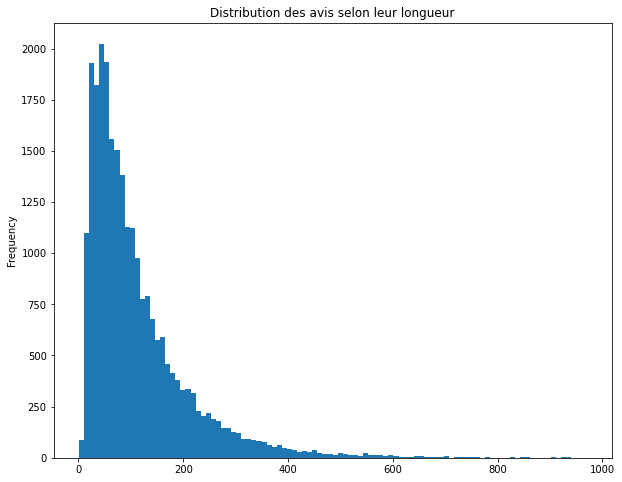

In [20]:
dataset_df.length.plot(kind="hist", bins=100, figsize=(10, 8), title='Distribution des avis selon leur longueur')

## 1.3 Distribution de la longueur des avis clients en fonction du nombre d'étoiles des avis

Text(0.5, 1.0, "Répartition des longueurs des avis en fonction du nombre d'étoiles")

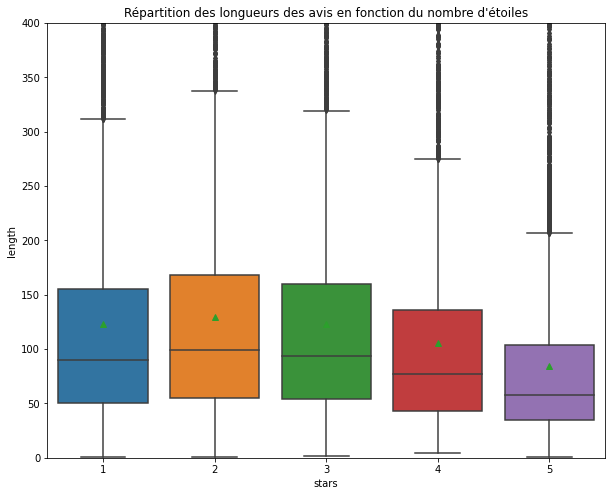

In [22]:
plt.figure(figsize=(10, 8))

ax = sns.boxplot(x=dataset_df.stars, y=dataset_df.length, showmeans=True)

ax.set_ylim(0, 400)

ax.set_title("Répartition des longueurs des avis en fonction du nombre d'étoiles")

# 2. Pré-traitement du jeu de données

# 2.1 Tokenisation (regexp) tkenizer et normalisation en minuscule


In [105]:
# Extending contracted expressions (e.g. wasn't -> was not)

dataset_df['token'] = [contractions.fix(x).lower() for x in dataset_df['text']] # .lower() transform les tokens en minuscule et .apply(tokenizer.tokenize) transforme en token
dataset_df.token[0]

"i have only had food from here once and it was not memorable. i had panang curry and the balance in flavor was not there. i like to taste the coconut, lemongrass, and lime, but it was lacking in east asia's offering. it was way too sweet. i do not care if the owners are not thai, i will eat anything if it is cooked well, but this place should not claim to serve thai food."

In [ ]:
dataset_df['token'] = [' '.join(tokens).split() for tokens in dataset_df['token'].apply(RegexpTokenizer(r"\w+").tokenize)] # or use RegexpTokenizer('\w+|\$[\d\.]+|\S+')
dataset_df.token[0]

In [111]:
for token in dataset_df['token']:
  for i in range(len(token)):
    if token[i] == 'not':
      if i < len(token)-1 :
        token[i+1] =  'not_' + token[i+1]
      else:
        token[i-1] += 'not_' + token[i-1]

token = [t for t in token if not t == 'not']        
dataset_df.token[0]

['i',
 'have',
 'only',
 'had',
 'food',
 'from',
 'here',
 'once',
 'and',
 'it',
 'was',
 'not_memorable',
 'i',
 'had',
 'panang',
 'curry',
 'and',
 'the',
 'balance',
 'in',
 'flavor',
 'was',
 'not',
 'not_not_not_not_there',
 'i',
 'like',
 'to',
 'taste',
 'the',
 'coconut',
 'lemongrass',
 'and',
 'lime',
 'but',
 'it',
 'was',
 'lacking',
 'in',
 'east',
 'asia',
 's',
 'offering',
 'it',
 'was',
 'way',
 'too',
 'sweet',
 'i',
 'do',
 'not',
 'not_not_not_not_care',
 'if',
 'the',
 'owners',
 'are',
 'not',
 'not_not_not_not_thai',
 'i',
 'will',
 'eat',
 'anything',
 'if',
 'it',
 'is',
 'cooked',
 'well',
 'but',
 'this',
 'place',
 'should',
 'not',
 'not_not_not_not_claim',
 'to',
 'serve',
 'thai',
 'food']

In [94]:
stop_words = set(stopwords.words('english'))
test = dataset_df['token'].apply(lambda x: [item for item in x if item not in stop_words])

In [96]:
test[0]

['food',
 'memorable',
 'panang',
 'curry',
 'balance',
 'flavor',
 'like',
 'taste',
 'coconut',
 'lemongrass',
 'lime',
 'lacking',
 'east',
 'asia',
 'offering',
 'way',
 'sweet',
 'care',
 'owners',
 'thai',
 'eat',
 'anything',
 'cooked',
 'well',
 'place',
 'claim',
 'serve',
 'thai',
 'food']

In [ ]:
lemmatizer = WordNetLemmatizer()

# 2.2 Convertir le texte en minuscule 